<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

Este trabajo se realizo con el evangelio de Juan de la biblia de jerusalen, fue a pedido de mi padrino de Jason que queria una representacion del evangelio para un retiro.
Por ello se hizo un scraper para traer el evangelio luego se limpio quitando los headers y luego se realizaron dos entrenamientos para comparar los resultados y evaluar la coherencia uno con los parametros usados en clase y un fittuneado por mi
Me di cuenta que habia demasiadas muestras de palabras stopwords y que incluso con el muestreo en negativo afectaban mucho el resultado.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.manifold import TSNE                   
import numpy as np        

### Datos
Utilizaremos como dataset el evangelio de Juan

In [65]:
# Cargar y limpiar el texto
with open('evangelio_juan_jerusalen.txt', 'r', encoding='utf-8') as file:
    lineas = file.readlines()

# Limpiar el texto eliminando titulos, separadores y lineas vacias
lineas_limpias = []
for linea in lineas:
    linea = linea.strip()
    if linea and not linea.startswith('=') and not linea.startswith('-') and not linea.startswith('CAPÍTULO') and not linea.startswith('EVANGELIO') and not linea.startswith('Biblia'):
        lineas_limpias.append(linea)

# Crear dataframe con las lineas limpias
df = pd.DataFrame(lineas_limpias, columns=['texto'])
print(f"Total de lineas procesadas: {len(df)}")
df.head()

Total de lineas procesadas: 1022


,texto
0,El Verbo hecho carne
1,"1 En el principio era el Verbo, y el Verbo era..."
2,Este era en el principio con Dios.
3,"Todas las cosas por él fueron hechas, y sin él..."
4,"En él estaba la vida, y la vida era la luz de ..."


In [66]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1022


### 1 - Preprocesamiento

In [115]:
sentence_tokens = []
for _, row in df.iterrows():
    sentence_tokens.append(text_to_word_sequence(row['texto']))

print(f"Total de oraciones tokenizadas: {len(sentence_tokens)}")

Total de oraciones tokenizadas: 1022


In [116]:
# Demos un vistazo
sentence_tokens[:2]

[['el', 'verbo', 'hecho', 'carne'],
 ['1\xa0en',
  'el',
  'principio',
  'era',
  'el',
  'verbo',
  'y',
  'el',
  'verbo',
  'era',
  'con',
  'dios',
  'y',
  'el',
  'verbo',
  'era',
  'dios']]

In [ ]:
# Filtrado de stopwords en español y validacion de palabras filtradas
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

all_words = Counter()
for sentence in sentence_tokens:
    all_words.update(sentence)

palabras_filtradas = {word: count for word, count in all_words.items() if word in stop_words}
print(f"\n=== Palabras que se FILTRARÁN ===")
print(f"Total: {len(palabras_filtradas)} palabras diferentes")
for word, count in sorted(palabras_filtradas.items(), key=lambda x: x[1], reverse=True):
    print(f"  {word:15s} {count:4d} veces")
sentence_tokens_filtered = []
for sentence in sentence_tokens:
    sentence = [word for word in sentence if word not in stop_words]
    if sentence:
        sentence_tokens_filtered.append(sentence)

print(f"\nOraciones originales: {len(sentence_tokens)}")
print(f"Oraciones filtradas: {len(sentence_tokens_filtered)}")


=== Palabras que se FILTRARÁN ===
Total: 192 palabras diferentes
Top 15 más frecuentes que se eliminarán:
  y                851 veces
  que              767 veces
  de               708 veces
  el               520 veces
  a                480 veces
  no               367 veces
  la               361 veces
  en               334 veces
  los              314 veces
  le               275 veces
  yo               189 veces
  él               171 veces
  me               168 veces
  al               150 veces
  es               146 veces
  porque           145 veces
  se               144 veces
  para             140 veces
  os               132 veces
  del              131 veces
  lo               121 veces
  vosotros         116 veces
  por              115 veces
  he               103 veces
  las              102 veces
  les              101 veces
  mi               100 veces
  mí                97 veces
  pero              93 veces
  había             93 veces
  su                90 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Entrenar el modelo

In [ ]:
# La modifique para que imprima cada 10 epochs
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.loss_previous_step = 0
        self.printed_epochs = set()

    def on_epoch_end(self, model):
        # Evitar impresiones duplicadas para la misma época
        if self.epoch in self.printed_epochs:
            self.epoch += 1
            return
            
        loss = model.get_latest_training_loss()
        
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.loss_previous_step = loss
            self.printed_epochs.add(self.epoch)
        elif self.epoch % 10 == 0:
            current_loss = loss - self.loss_previous_step
            print('Loss after epoch {}: {}'.format(self.epoch, current_loss))
            self.loss_previous_step = loss
            self.printed_epochs.add(self.epoch)
        
        self.epoch += 1

In [120]:
# Promero voy probar con el entrenamiento usado en la clase aunque creo que para este caso podemos mejorarlo
w2v_model = Word2Vec(min_count=3,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=100,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram
# Construir vocabulario
w2v_model.build_vocab(sentence_tokens)



# Entrenar con callback para ver progreso
w2v_model.train(
    sentence_tokens,
    total_examples=w2v_model.corpus_count,
    epochs=100,                # Épocas aumentadas para mejor convergencia
    compute_loss=True,
    callbacks=[callback()],
    report_delay=1.0
)
print(f"Vocabulario: {len(w2v_model.wv.index_to_key)} palabras")
print(f"Corpus: {w2v_model.corpus_count} documentos")

Loss after epoch 0: 193570.046875
Loss after epoch 10: 1041603.328125
Loss after epoch 20: 823444.0
Loss after epoch 30: 686947.875
Loss after epoch 40: 650580.5
Loss after epoch 50: 628611.25
Loss after epoch 60: 587700.5
Loss after epoch 70: 568124.5
Loss after epoch 80: 557452.0
Loss after epoch 90: 553256.5
Vocabulario: 765 palabras
Corpus: 1022 documentos


In [ ]:
# Contar frecuencia de  palabras para dataset con stopwords
word_freq = Counter()
for sentence in sentence_tokens:
    word_freq.update(sentence)

print("=== Análisis de Frecuencias de Palabras ===")
print(f"Total de palabras únicas (sin filtro): {len(word_freq)}")
print(f"Total de palabras únicas (min_count=3): {len([w for w, c in word_freq.items() if c >= 3])}")
print(f"Total de palabras únicas (min_count=2): {len([w for w, c in word_freq.items() if c >= 2])}")
print(f"Total de palabras únicas (min_count=1): {len([w for w, c in word_freq.items() if c >= 1])}")

print(f"\n=== Palabras más frecuentes ===")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")

print(f"\n=== Distribución de frecuencias ===")
freq_1 = len([w for w, c in word_freq.items() if c == 1])
freq_2 = len([w for w, c in word_freq.items() if c == 2])
freq_3_5 = len([w for w, c in word_freq.items() if 3 <= c <= 5])
freq_6_10 = len([w for w, c in word_freq.items() if 6 <= c <= 10])
freq_10_plus = len([w for w, c in word_freq.items() if c > 10])

print(f"Palabras con frecuencia = 1: {freq_1} ({freq_1/len(word_freq)*100:.1f}%)")
print(f"Palabras con frecuencia = 2: {freq_2} ({freq_2/len(word_freq)*100:.1f}%)")
print(f"Palabras con frecuencia 3-5: {freq_3_5} ({freq_3_5/len(word_freq)*100:.1f}%)")
print(f"Palabras con frecuencia 6-10: {freq_6_10} ({freq_6_10/len(word_freq)*100:.1f}%)")
print(f"Palabras con frecuencia >10: {freq_10_plus} ({freq_10_plus/len(word_freq)*100:.1f}%)")

=== Análisis de Frecuencias de Palabras ===
Total de palabras únicas (sin filtro): 2242
Total de palabras únicas (min_count=3): 765
Total de palabras únicas (min_count=2): 1112
Total de palabras únicas (min_count=1): 2242

=== Palabras más frecuentes ===
y: 851
que: 767
de: 708
el: 520
a: 480
no: 367
la: 361
en: 334
los: 314
jesús: 299
le: 275
dijo: 224
yo: 189
él: 171
me: 168
al: 150
es: 146
porque: 145
se: 144
para: 140

=== Distribución de frecuencias ===
Palabras con frecuencia = 1: 1130 (50.4%)
Palabras con frecuencia = 2: 347 (15.5%)
Palabras con frecuencia 3-5: 340 (15.2%)
Palabras con frecuencia 6-10: 179 (8.0%)
Palabras con frecuencia >10: 246 (11.0%)


In [121]:
# Contar frecuencia de  palabras para dataset con stopwords
word_freq_filtered = Counter()
for sentence in sentence_tokens_filtered:
    word_freq_filtered.update(sentence)
print("=== Análisis de Frecuencias de Palabras (con stopwords) ===")
print(f"Total de palabras únicas (sin filtro): {len(word_freq_filtered)}")
print(f"Total de palabras únicas (min_count=3): {len([w for w, c in word_freq_filtered.items() if c >= 3])}")
print(f"Total de palabras únicas (min_count=2): {len([w for w, c in word_freq_filtered.items() if c >= 2])}")
print(f"Total de palabras únicas (min_count=1): {len([w for w, c in word_freq_filtered.items() if c >= 1])}")   
print(f"\n=== Palabras más frecuentes (con stopwords) ===")
for word, count in word_freq_filtered.most_common(20):
    print(f"{word}: {count}")
print(f"\n=== Distribución de frecuencias (con stopwords) ===")
freq_1 = len([w for w, c in word_freq_filtered.items() if c == 1])
freq_2 = len([w for w, c in word_freq_filtered.items() if c == 2])
freq_3_5 = len([w for w, c in word_freq_filtered.items() if 3 <= c <= 5])
freq_6_10 = len([w for w, c in word_freq_filtered.items() if 6 <= c <= 10])
freq_10_plus = len([w for w, c in word_freq_filtered.items() if c > 10])    
print(f"Palabras con frecuencia = 1: {freq_1} ({freq_1/len(word_freq_filtered)*100:.1f}%)")
print(f"Palabras con frecuencia = 2: {freq_2} ({freq_2/len(word_freq_filtered)*100:.1f}%)")
print(f"Palabras con frecuencia 3-5: {freq_3_5} ({freq_3_5/len(word_freq_filtered)*100:.1f}%)")
print(f"Palabras con frecuencia 6-10: {freq_6_10} ({freq_6_10/len(word_freq_filtered)*100:.1f}%)")
print(f"Palabras con frecuencia >10: {freq_10_plus} ({freq_10_plus/len(word_freq_filtered)*100:.1f}%)")


=== Análisis de Frecuencias de Palabras (con stopwords) ===
Total de palabras únicas (sin filtro): 2050
Total de palabras únicas (min_count=3): 617
Total de palabras únicas (min_count=2): 951
Total de palabras únicas (min_count=1): 2050

=== Palabras más frecuentes (con stopwords) ===
jesús: 299
dijo: 224
padre: 137
entonces: 113
si: 89
dios: 87
mundo: 84
judíos: 70
discípulos: 69
hijo: 67
respondió: 66
sino: 64
pues: 59
dijeron: 58
mas: 56
señor: 54
cierto: 51
vida: 50
hombre: 49
dicho: 49

=== Distribución de frecuencias (con stopwords) ===
Palabras con frecuencia = 1: 1099 (53.6%)
Palabras con frecuencia = 2: 334 (16.3%)
Palabras con frecuencia 3-5: 313 (15.3%)
Palabras con frecuencia 6-10: 151 (7.4%)
Palabras con frecuencia >10: 153 (7.5%)


In [124]:
# Modelo optimizado con tokens filtrados (sin stopwords)
w2v_final = Word2Vec(
    # min_count: Frecuencia mínima para incluir palabra en vocabulario
    # Valor 2: Incluye palabras que aparecen al menos 2 veces
    # Esperado: Reducir ruido de palabras muy raras pero capturar más vocabulario teológico específico
    min_count=2,
    
    # window: Tamaño de ventana de contexto (palabras antes y después de la palabra objetivo)
    # Valor 7: Considera 7 palabras hacia adelante y 7 hacia atrás (total 14 palabras de contexto)
    # Esperado: Capturar relaciones semánticas más amplias en texto narrativo/teológico
    # Mayor que el baseline (window=2) para contextos más ricos
    window=7,
    
    # vector_size: Dimensionalidad de los vectores de embedding
    # Valor 150: Cada palabra se representa con 150 dimensiones
    # Esperado: Mayor capacidad expresiva que baseline (100), mejor para vocabulario religioso complejo
    # Permite capturar más matices semánticos sin sobreajuste en corpus pequeño
    vector_size=150,
    
    # sg: Algoritmo de entrenamiento (0=CBOW, 1=Skip-gram)
    # Valor 1: Skip-gram - predice palabras de contexto dada palabra central
    # Esperado: Mejor para corpus pequeños y palabras poco frecuentes
    # Ideal para términos teológicos específicos que aparecen pocas veces
    sg=1,
    
    # negative: Número de muestras negativas para negative sampling
    # Valor 15: Por cada ejemplo positivo, usa 15 negativos aleatorios
    # Esperado: Balance entre calidad y velocidad
    # Ayuda a distinguir palabras similares de las no relacionadas
    negative=5, 
    
    # alpha: Tasa de aprendizaje inicial
    # Valor 0.025: Tasa estándar de aprendizaje
    # Esperado: Convergencia estable sin oscilaciones
    alpha=0.025,
    
    # min_alpha: Tasa de aprendizaje mínima (decae linealmente desde alpha)
    # Valor 0.0001: Permite ajustes finos al final del entrenamiento
    # Esperado: Refinamiento de embeddings en últimas épocas
    min_alpha=0.0001,
    

    workers=1,
    seed=42,
    
    # hs: Usar Hierarchical Softmax
    # Valor 0: Desactivado, usa negative sampling en su lugar
    # Esperado: Más eficiente para vocabularios medianos con negative sampling
    hs=1
)

# Construir vocabulario a partir de tokens filtrados (sin stopwords)
w2v_final.build_vocab(sentence_tokens_filtered)

print(f"\nVocabulario: {len(w2v_final.wv.index_to_key)} palabras")
print(f"Corpus: {w2v_final.corpus_count} documentos")

# Entrenar el modelo
w2v_final.train(
    sentence_tokens_filtered,  # Corpus sin stopwords
    total_examples=w2v_final.corpus_count,  # Total de documentos
    epochs=150,  # 150 iteraciones sobre el corpus completo - más que baseline para mejor convergencia
    compute_loss=True,  # Calcular pérdida para monitorear progreso
    callbacks=[callback()],  # Imprimir loss cada 10 épocas
    report_delay=1.0  # Retraso en segundos para reportes
)



Vocabulario: 951 palabras
Corpus: 1022 documentos
Loss after epoch 0: 279870.59375
Loss after epoch 10: 2141424.65625
Loss after epoch 10: 2141424.65625
Loss after epoch 20: 1591333.5
Loss after epoch 20: 1591333.5
Loss after epoch 30: 1317914.75
Loss after epoch 30: 1317914.75
Loss after epoch 40: 1254691.5
Loss after epoch 40: 1254691.5
Loss after epoch 50: 1228887.0
Loss after epoch 50: 1228887.0
Loss after epoch 60: 1162606.0
Loss after epoch 60: 1162606.0
Loss after epoch 70: 1118785.0
Loss after epoch 70: 1118785.0
Loss after epoch 80: 1125503.0
Loss after epoch 80: 1125503.0
Loss after epoch 90: 1118536.0
Loss after epoch 90: 1118536.0
Loss after epoch 100: 1119950.0
Loss after epoch 100: 1119950.0
Loss after epoch 110: 1128238.0
Loss after epoch 110: 1128238.0
Loss after epoch 120: 1130965.0
Loss after epoch 120: 1130965.0
Loss after epoch 130: 1103793.0
Loss after epoch 130: 1103793.0
Loss after epoch 140: 587236.0
Loss after epoch 140: 587236.0


(873937, 1255500)

In [125]:
# Comparar resultados entre modelo original y optimizado
print("=== COMPARACIÓN DE RESULTADOS ===\n")

test_words = ["jesús", "dios", "pan", "amor", "discípulo", "cristo", "agua", "ver", "cielo", "pecado", "corazón", "cordero","cree","pastor"]

for word in test_words:
    print(f"\nPalabra: '{word}'")
    print("="*60)
    
    print(f"\nModelo con parametros del note de la CLASE:")
    try:
        similar_old = w2v_model.wv.most_similar(positive=[word], topn=5)
        for similar_word, score in similar_old:
            print(f"  {similar_word:20s} {score:.3f}")
    except KeyError:
        print(f"  '{word}' no está en el vocabulario")
    
    print(f"\nModelo OPTIMIZADO:")
    try:
        similar_new = w2v_final.wv.most_similar(positive=[word], topn=5)
        for similar_word, score in similar_new:
            print(f"  {similar_word:20s} {score:.3f}")
    except KeyError:
        print(f"  '{word}' no está en el vocabulario")

=== COMPARACIÓN DE RESULTADOS ===


Palabra: 'jesús'

Modelo con parametros del note de la CLASE:
  volviéndose          0.441
  natanael             0.439
  recostado            0.434
  hubieron             0.422
  llevaron             0.418

Modelo OPTIMIZADO:
  dijo                 0.391
  huerto               0.241
  juntos               0.222
  recibió              0.219
  limpios              0.212

Palabra: 'dios'

Modelo con parametros del note de la CLASE:
  suyo                 0.488
  voluntad             0.461
  abraham              0.456
  manera               0.456
  ladrón               0.435

Modelo OPTIMIZADO:
  único                0.332
  recibís              0.314
  glorificará          0.295
  gloria               0.291
  verbo                0.288

Palabra: 'pan'

Modelo con parametros del note de la CLASE:
  descendió            0.664
  come                 0.522
  vivirá               0.503
  vivo                 0.469
  amigo                0.468

Modelo OPTIMI

In [126]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_final.corpus_count)

Cantidad de docs en el corpus: 1022


In [127]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_final.wv.index_to_key))

Cantidad de words distintas en el corpus: 951


In [128]:
# Palabras que MÁS se relacionan con...:
w2v_final.wv.most_similar(positive=["dios"], topn=15)

[('único', 0.33211976289749146),
 ('recibís', 0.3142957389354706),
 ('glorificará', 0.29473868012428284),
 ('gloria', 0.2907024323940277),
 ('verbo', 0.28798985481262207),
 ('propio', 0.2799665629863739),
 ('unigénito', 0.27726632356643677),
 ('pecador', 0.2755340039730072),
 ('quebrantada', 0.26969558000564575),
 ('gracia', 0.2582153081893921),
 ('creed', 0.25685232877731323),
 ('recibo', 0.2545771300792694),
 ('haré', 0.25328949093818665),
 ('adoren', 0.25212010741233826),
 ('ser', 0.2493838518857956)]

In [129]:
# Palabras que MENOS se relacionan con...:
w2v_final.wv.most_similar(negative=["dios"], topn=10)

[('piedra', 0.1387805938720703),
 ('sane', 0.07375340908765793),
 ('días', 0.06902489811182022),
 ('volvió', 0.06848905235528946),
 ('lugar', 0.06783412396907806),
 ('tras', 0.06199432909488678),
 ('manto', 0.05730913206934929),
 ('gracias', 0.0546087771654129),
 ('mesa', 0.04900865629315376),
 ('va', 0.04547703638672829)]

In [130]:
# Palabras que MÁS se relacionan con...:
w2v_final.wv.most_similar(positive=["cristo"], topn=10)

[('mesías', 0.46253854036331177),
 ('confesó', 0.4613170921802521),
 ('testigos', 0.4257442057132721),
 ('mismos', 0.40809810161590576),
 ('david', 0.40274256467819214),
 ('creemos', 0.3721145689487457),
 ('veis', 0.3426511287689209),
 ('linaje', 0.3412196636199951),
 ('conseguís', 0.3394203782081604),
 ('señal', 0.3354659378528595)]

In [131]:
# Palabras que MÁS se relacionan con...:
w2v_final.wv.most_similar(positive=["jesús"], topn=10)

[('dijo', 0.39130786061286926),
 ('huerto', 0.24051301181316376),
 ('juntos', 0.2223542481660843),
 ('recibió', 0.21886102855205536),
 ('limpios', 0.21224774420261383),
 ('entrar', 0.2071082890033722),
 ('casa', 0.20469878613948822),
 ('ahí', 0.2044931948184967),
 ('sudario', 0.20171372592449188),
 ('templo', 0.19960400462150574)]

In [132]:
w2v_final.wv.most_similar(negative=["cordero"])

[('muera', 0.09090331196784973),
 ('todas', 0.07124458998441696),
 ('significa', 0.06610425561666489),
 ('maestresala', 0.05207454413175583),
 ('saber', 0.04945145919919014),
 ('conocido', 0.04686952754855156),
 ('sacado', 0.046001236885786057),
 ('sabían', 0.04538512974977493),
 ('hará', 0.04420333728194237),
 ('vino', 0.033735331147909164)]

In [133]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["amor"], topn=10)

[('mandamientos', 0.6783647537231445),
 ('tenéis', 0.5802463293075562),
 ('vean', 0.571662187576294),
 ('sean', 0.5392321348190308),
 ('enviaste', 0.5264083743095398),
 ('conozco', 0.5138974189758301),
 ('conoce', 0.5112057328224182),
 ('hacéis', 0.5086387395858765),
 ('cinco', 0.5077720284461975),
 ('dijere', 0.5033248662948608)]

In [134]:
w2v_model.wv.most_similar(negative=["cristo"], topn=10)

[('llama', 0.016373954713344574),
 ('piernas', -0.027289533987641335),
 ('hicieron', -0.0295331459492445),
 ('había', -0.030025653541088104),
 ('he', -0.03179452568292618),
 ('habiendo', -0.03701341897249222),
 ('manos', -0.04116760566830635),
 ('primero', -0.04302511736750603),
 ('madre', -0.043930329382419586),
 ('dijo', -0.04868847131729126)]

### 5 - Visualizar agrupación de vectores

In [135]:
def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

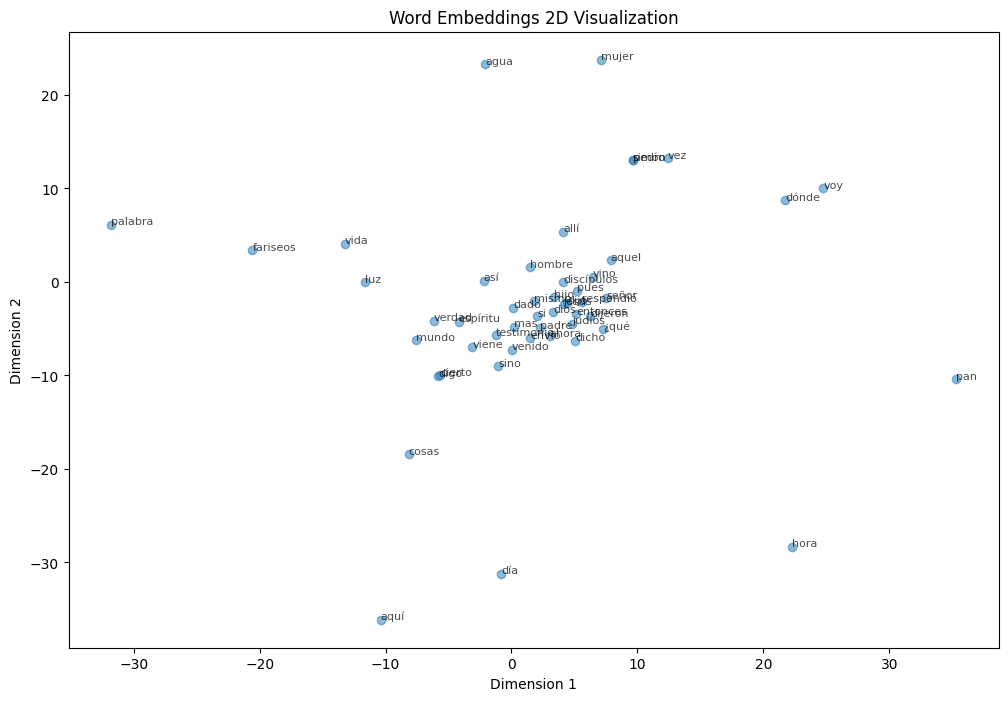

In [138]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_final)

MAX_WORDS=50
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
plt.figure(figsize=(12, 8))
plt.scatter(vecs[:MAX_WORDS,0], vecs[:MAX_WORDS,1], alpha=0.5)
for i, label in enumerate(labels[:MAX_WORDS]):
    plt.annotate(label, (vecs[i,0], vecs[i,1]), fontsize=8, alpha=0.7)
plt.title('Word Embeddings 2D Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# no hago la graficacion en 3D por que no me permite intercatuar el grafico por que estoy en un notebook en mi pc

In [144]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/

vectors = np.asarray(w2v_final.wv.vectors)
labels = list(w2v_final.wv.index_to_key)

# Guardar vectores
np.savetxt("vectors.tsv", vectors, delimiter="\t")

# CORRECCIÓN FINAL
with open("labels.tsv", "w", encoding='utf-8') as fp:
    for item in labels:
        # Limpiar caracteres especiales invisibles
        cleaned_item = item.strip()
        # Si después de limpiar queda vacío, usar un placeholder
        if not cleaned_item or cleaned_item.isspace():
            cleaned_item = "[ESPACIO_UNICODE]"
        fp.write("%s\n" % cleaned_item)


# Verificaciones de los archivos generados para la representación, habia problemas con projector de tensorflow no coincidian los largos de los archivos. por caracter especiales en las palabras

In [141]:
# Verificar que ahora todo cuadre
print("=== Verificación final ===")
print(f"Número de vectores: {len(w2v_final.wv.vectors)}")

with open("vectors.tsv", "r") as f:
    num_vector_lines = sum(1 for _ in f)
print(f"Líneas en vectors.tsv: {num_vector_lines}")

with open("labels.tsv", "r") as f:
    lines = f.readlines()
    num_label_lines = len(lines)
    print(f"Líneas totales en labels.tsv: {num_label_lines}")
    print(f"Primera línea (encabezado): '{lines[0].strip()}'")
    print(f"Líneas de datos (sin encabezado): {num_label_lines - 1}")
    print(f"\nPrimeras 5 palabras (después del encabezado):")
    for i in range(1, min(6, len(lines))):
        print(f"  - {lines[i].strip()}")

=== Verificación final ===
Número de vectores: 951
Líneas en vectors.tsv: 951
Líneas totales en labels.tsv: 951
Primera línea (encabezado): 'jesús'
Líneas de datos (sin encabezado): 950

Primeras 5 palabras (después del encabezado):
  - dijo
  - padre
  - entonces
  - si
  - dios


In [142]:
# tuve que revisar por que no me coincidian el largo de label con los vectores y me di cuenta cuando lo subia a la represenatcion 
# en tensorflow despues revise el archivo a mano y hay algunas labels que tenian algun tipo de caracter especial 
def verificar_archivos_tsv():
    """
    Verifica que los archivos vectors.tsv y labels.tsv sean consistentes
    """
    # Leer archivos
    with open("labels.tsv", "r", encoding='utf-8') as f:
        labels_lines = f.readlines()
    
    with open("vectors.tsv", "r", encoding='utf-8') as f:
        vectors_lines = f.readlines()
    
    # Obtener datos del modelo
    model_vocab = w2v_final.wv.index_to_key
    model_vectors = len(w2v_final.wv.vectors)
    
    # Contadores
    total_labels = len(labels_lines)
    total_vectors = len(vectors_lines)
    errores = []
    espacios_unicode = 0
    
    # Verificar cada línea
    for i in range(min(total_labels, len(model_vocab))):
        file_word = labels_lines[i].strip()
        model_word = model_vocab[i]
        
        # Detectar caracteres especiales
        if model_word.strip() == '':
            espacios_unicode += 1
            if file_word != '[ESPACIO_UNICODE]':
                errores.append({
                    'linea': i + 1,
                    'archivo': file_word,
                    'modelo': repr(model_word),
                    'tipo': 'Espacio Unicode no reemplazado'
                })
        elif file_word != model_word:
            errores.append({
                'linea': i + 1,
                'archivo': file_word,
                'modelo': model_word,
                'tipo': 'No coinciden'
            })
    
    # Reporte
    print("VERIFICACIÓN DE ARCHIVOS TSV")
    print("-" * 60)
    print(f"Vocabulario del modelo: {len(model_vocab)} palabras")
    print(f"Líneas en labels.tsv: {total_labels}")
    print(f"Líneas en vectors.tsv: {total_vectors}")
    print(f"Espacios Unicode encontrados: {espacios_unicode}")
    print()
    
    if total_labels == total_vectors == len(model_vocab):
        print("ESTADO: Dimensiones correctas")
    else:
        print("ADVERTENCIA: Dimensiones no coinciden")
    
    if errores:
        print(f"\nERRORES ENCONTRADOS: {len(errores)}")
        print("\nPrimeros 10 errores:")
        for error in errores[:10]:
            print(f"  Línea {error['linea']}: {error['tipo']}")
            print(f"    Archivo: '{error['archivo']}'")
            print(f"    Modelo: '{error['modelo']}'")
    else:
        print("\nRESULTADO: Todos los datos coinciden correctamente")
        print("Los archivos están listos para TensorFlow Projector")
    
    print("-" * 60)
    
    return {
        'total_palabras': len(model_vocab),
        'errores': len(errores),
        'espacios_unicode': espacios_unicode,
        'estado': 'OK' if not errores else 'ERRORES'
    }

# Ejecutar verificación
resultado = verificar_archivos_tsv()

VERIFICACIÓN DE ARCHIVOS TSV
------------------------------------------------------------
Vocabulario del modelo: 951 palabras
Líneas en labels.tsv: 951
Líneas en vectors.tsv: 951
Espacios Unicode encontrados: 1

ESTADO: Dimensiones correctas

RESULTADO: Todos los datos coinciden correctamente
Los archivos están listos para TensorFlow Projector
------------------------------------------------------------
